In [1]:
import grewpy
import yaml
import sys
import numpy as np

sys.path.insert(1, '/Users/madalina/Documents/M2TAL/stage/grex/grex2')
import pyximport
pyximport.install()
import grex.data
import grex.utils
import grex.features

connected to port: 52625


In [2]:
path = "/Users/madalina/Documents/M1TAL/stage-SK/Treebanks/UD_French-GSD-master"
grewpy.set_config('ud')
corpus = grewpy.Corpus(path)
draft = grewpy.CorpusDraft(corpus)

In [4]:
all_matches = corpus.search(grewpy.Request("X[upos=ADV]"), clustering_parameter=['X.lemma'])

In [5]:
matches = {}
for key, value in all_matches.items():
    # remove those that have less than 10 occurrences
    if len(value) > 10:
        matches[key] = value

In [6]:
with open("../3. probability_matrix/patterns_adv.txt") as instream:
    config = yaml.load(instream, Loader=yaml.Loader)

templates = grex.utils.FeaturePredicate.from_config(config["templates"])
feature_predicate = grex.utils.FeaturePredicate.from_config(config["features"], templates=templates)

In [7]:
data = { k : list() for k in matches }
for adv, mts in matches.items():
    for match in mts:
        features = grex.data.extract_features(draft, match, feature_predicate)
        formatted_features = [
            f"{':'.join(k)}={v}" if not isinstance(v, set) else
            f"{':'.join(k)}={val}" for k, v in features.items() for val in (v if isinstance(v, set) else [v])
        ]
        data[adv].append(formatted_features)

In [8]:
unique_adv = sorted(set([k for k in data]))
unique_features = sorted(set([feat for _, matches in data.items() for m in matches for feat in m]))

idx2feature = {i : feat for i, feat in enumerate(unique_features) }
feature2idx = {feat : i for i, feat in idx2feature.items()}
idx2adv = {i : feat for i, feat in enumerate(unique_adv) }
adv2idx = {feat : i for i, feat in idx2adv.items()}

In [9]:
X = np.zeros((len(data.keys()), len(unique_features)))
for adv, samples in data.items():
    n_samples = len(matches)
    for m in samples:
        for feature in m:
            X[adv2idx[adv], feature2idx[feature]] += 1
    X[adv2idx[adv]] = X[adv2idx[adv]] / n_samples
print(f"{X.shape=}")

X.shape=(127, 209)


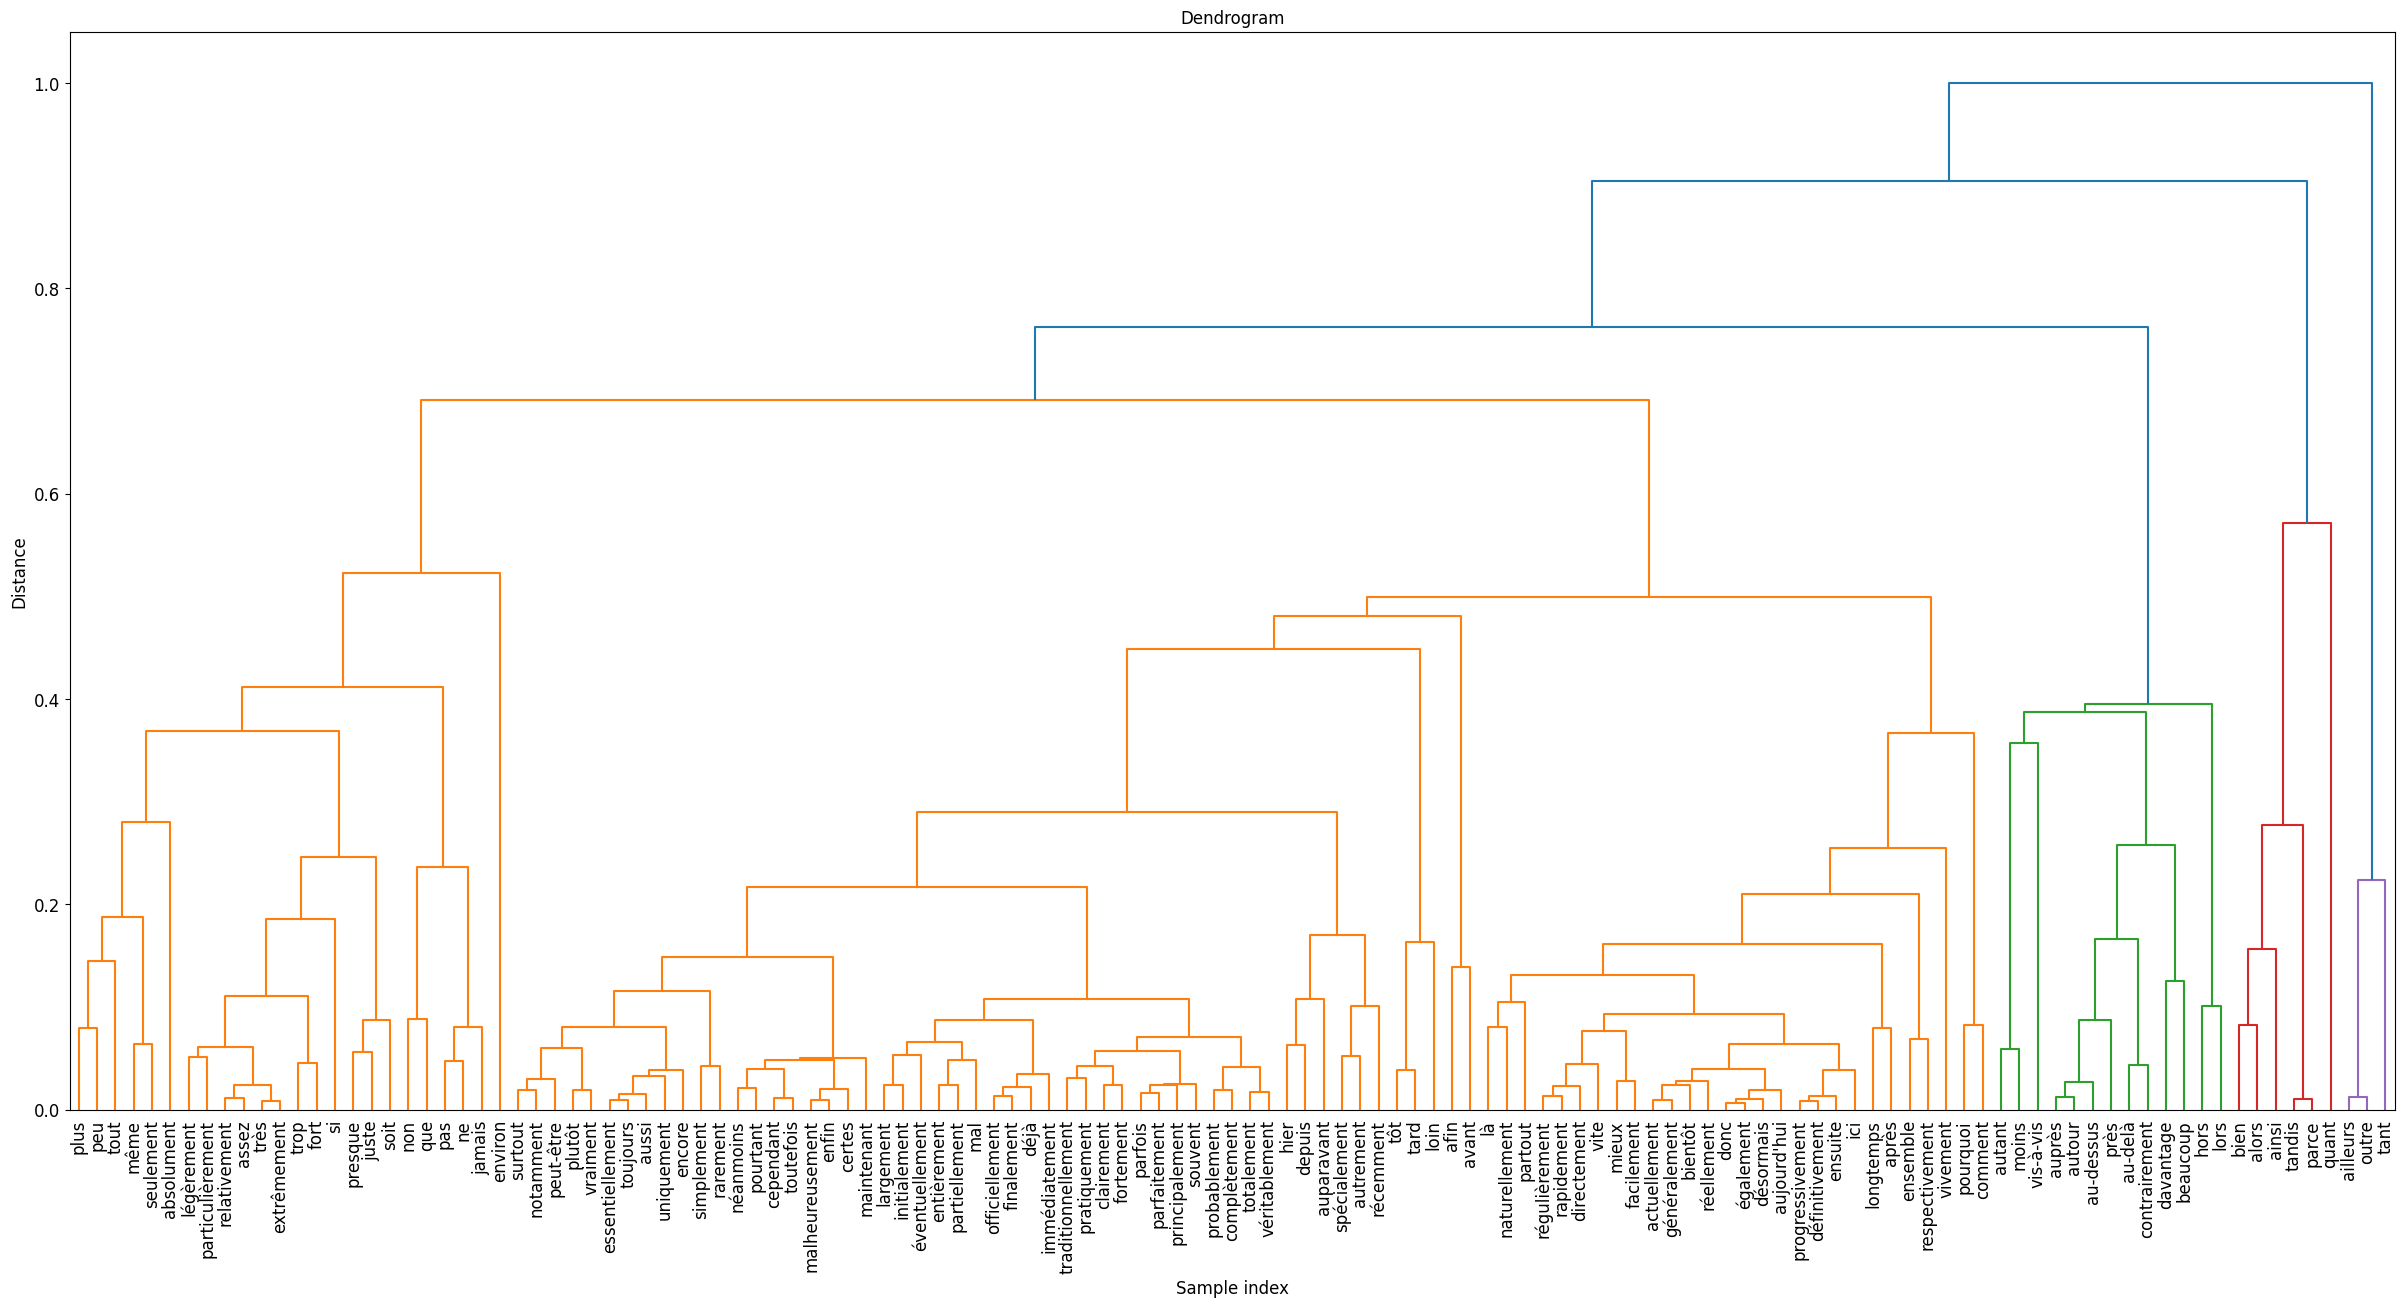

In [10]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
import matplotlib.pyplot as plt

# Hamming or jacard for categorical data, cosine for sparse matrices (normally used in NLP)
# I compute the distance for each pair of lines, each POS
distance_matrix = pdist(X, metric='cosine')
# Complete -> we cluster 
linked = linkage(distance_matrix, method="complete", optimal_ordering=True)

plt.figure(figsize=(30, 14))

dn = dendrogram(linked,
                orientation='top',
                labels=[name for name in unique_adv],
                distance_sort='descending',
                show_leaf_counts=True,
                get_leaves=True)

plt.title('Dendrogram', fontsize=12)  # Increase title font size
plt.xlabel('Sample index', fontsize=12)  # Increase x-axis label font size
plt.ylabel('Distance', fontsize=12)  # Increase y-axis label font size
plt.xticks(fontsize=12)  # Increase x-tick labels font size
plt.yticks(fontsize=12)  # Increase y-tick labels font size
plt.show()

In [11]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

def find_optimal_clusters(X, max_clusters=20, metric='cosine', method='complete'):
    distance_matrix = pdist(X, metric=metric)
    linked = linkage(distance_matrix, method=method, optimal_ordering=True)
    
    silhouette_scores = []
    for num_clusters in range(2, max_clusters + 1):
        labels = fcluster(linked, num_clusters, criterion='maxclust')
        if len(np.unique(labels)) > 1:  # Ensure there is more than one cluster
            score = silhouette_score(X, labels, metric=metric)
            silhouette_scores.append(score)
            print(f'Number of clusters: {num_clusters}, Silhouette Score: {score}')
        else:
            silhouette_scores.append(-1)  # Append a low score if only one cluster
    
    optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2
    return optimal_clusters, silhouette_scores

# Find the optimal number of clusters
optimal_clusters, silhouette_scores = find_optimal_clusters(X, max_clusters=50)
print(f'Optimal number of clusters: {optimal_clusters}')
print(X.shape)

Number of clusters: 2, Silhouette Score: 0.6668967626707801
Number of clusters: 3, Silhouette Score: 0.4899218199317488
Number of clusters: 4, Silhouette Score: 0.49231980834918254
Number of clusters: 5, Silhouette Score: 0.3765541298639011
Number of clusters: 6, Silhouette Score: 0.38145488332705885
Number of clusters: 7, Silhouette Score: 0.3680033269498997
Number of clusters: 8, Silhouette Score: 0.18965995457324125
Number of clusters: 9, Silhouette Score: 0.2139379688054042
Number of clusters: 10, Silhouette Score: 0.2421923532420217
Number of clusters: 11, Silhouette Score: 0.27625971240783
Number of clusters: 12, Silhouette Score: 0.27970586924671204
Number of clusters: 13, Silhouette Score: 0.2849212692397349
Number of clusters: 14, Silhouette Score: 0.2903560955988233
Number of clusters: 15, Silhouette Score: 0.30634016863887154
Number of clusters: 16, Silhouette Score: 0.30490324404393887
Number of clusters: 17, Silhouette Score: 0.2945560490662871
Number of clusters: 18, Silh

In [24]:
# see what there is in each cluster
labels = fcluster(linked, optimal_clusters, criterion='maxclust')
clusters = {i: [] for i in range(1, optimal_clusters + 1)}
for i, label in enumerate(labels):
    clusters[label].append(i)

for cluster, members in clusters.items():
    print(f'Cluster {cluster}:')
    for member in members:
        print(f'  {unique_adv[member]}')

Cluster 1:
  ailleurs
  outre
  tant
Cluster 2:
  absolument
  actuellement
  afin
  ainsi
  alors
  après
  assez
  au-delà
  au-dessus
  aujourd'hui
  auparavant
  auprès
  aussi
  autant
  autour
  autrement
  avant
  beaucoup
  bien
  bientôt
  cependant
  certes
  clairement
  comment
  complètement
  contrairement
  davantage
  depuis
  directement
  donc
  définitivement
  déjà
  désormais
  encore
  enfin
  ensemble
  ensuite
  entièrement
  environ
  essentiellement
  extrêmement
  facilement
  finalement
  fort
  fortement
  généralement
  hier
  hors
  ici
  immédiatement
  initialement
  jamais
  juste
  largement
  loin
  longtemps
  lors
  là
  légèrement
  maintenant
  mal
  malheureusement
  mieux
  moins
  même
  naturellement
  ne
  non
  notamment
  néanmoins
  officiellement
  parce
  parfaitement
  parfois
  particulièrement
  partiellement
  partout
  pas
  peu
  peut-être
  plus
  plutôt
  pourquoi
  pourtant
  pratiquement
  presque
  principalement
  probableme

In [25]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for Plotly
df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': labels,
    'Word': unique_adv
})
# pca1_min, pca1_max = df['PCA1'].min(), df['PCA1'].max()
# pca2_min, pca2_max = df['PCA2'].min(), df['PCA2'].max()
# Create a scatter plot with Plotly
fig = go.Figure()

# Add traces for each cluster
for cluster in range(1, optimal_clusters + 1):
    cluster_data = df[df['Cluster'] == cluster]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(size=10),
        name=f'Cluster {cluster}',
        text=cluster_data['Word'],
        hoverinfo='text'
    ))

# Update layout with dropdown menu
fig.update_layout(
    title='Word Clusters',
    xaxis_title='PCA1',
    yaxis_title='PCA2',
    # xaxis=dict(range=[pca1_min, pca1_max]),
    # yaxis=dict(range=[pca2_min, pca2_max]),
    updatemenus=[
        {
            'buttons': [
                {
                    'label': 'All Clusters',
                    'method': 'update',
                    'args': [{'visible': [True] * optimal_clusters},
                             {'title': 'All Clusters'}]
                }
            ] + [
                {
                    'label': f'Cluster {i}',
                    'method': 'update',
                    'args': [{'visible': [j == i - 1 for j in range(optimal_clusters)]},
                             {'title': f'Cluster {i}'}]
                } for i in range(1, optimal_clusters + 1)
            ],
            'direction': 'down',
            'showactive': True
        }
    ]
)

fig.show()

# If we also remove those that are part of an idiom

In [46]:
all_matches = corpus.search(grewpy.Request("X[upos=ADV]").without("X[InIdiom]").without("X[Idiom]"), clustering_parameter=['X.lemma'])

In [47]:
matches = {}
for key, value in all_matches.items():
    # remove those that have less than 10 occurrences
    if len(value) > 10:
        matches[key] = value

In [48]:
with open("patterns_adv_no_idioms.txt") as instream:
    config = yaml.load(instream, Loader=yaml.Loader)

templates = grex.utils.FeaturePredicate.from_config(config["templates"])
feature_predicate = grex.utils.FeaturePredicate.from_config(config["features"], templates=templates)

In [49]:
data = { k : list() for k in matches }
for adv, mts in matches.items():
    for match in mts:
        features = grex.data.extract_features(draft, match, feature_predicate)
        formatted_features = [
            f"{':'.join(k)}={v}" if not isinstance(v, set) else
            f"{':'.join(k)}={val}" for k, v in features.items() for val in (v if isinstance(v, set) else [v])
        ]
        data[adv].append(formatted_features)

In [50]:
unique_adv = sorted(set([k for k in data]))
unique_features = sorted(set([feat for _, matches in data.items() for m in matches for feat in m]))

idx2feature = {i : feat for i, feat in enumerate(unique_features) }
feature2idx = {feat : i for i, feat in idx2feature.items()}
idx2adv = {i : feat for i, feat in enumerate(unique_adv) }
adv2idx = {feat : i for i, feat in idx2adv.items()}

In [51]:
X = np.zeros((len(data.keys()), len(unique_features)))
for adv, samples in data.items():
    n_samples = len(matches)
    for m in samples:
        for feature in m:
            X[adv2idx[adv], feature2idx[feature]] += 1
    X[adv2idx[adv]] = X[adv2idx[adv]] / n_samples
print(f"{X.shape=}")

X.shape=(123, 185)


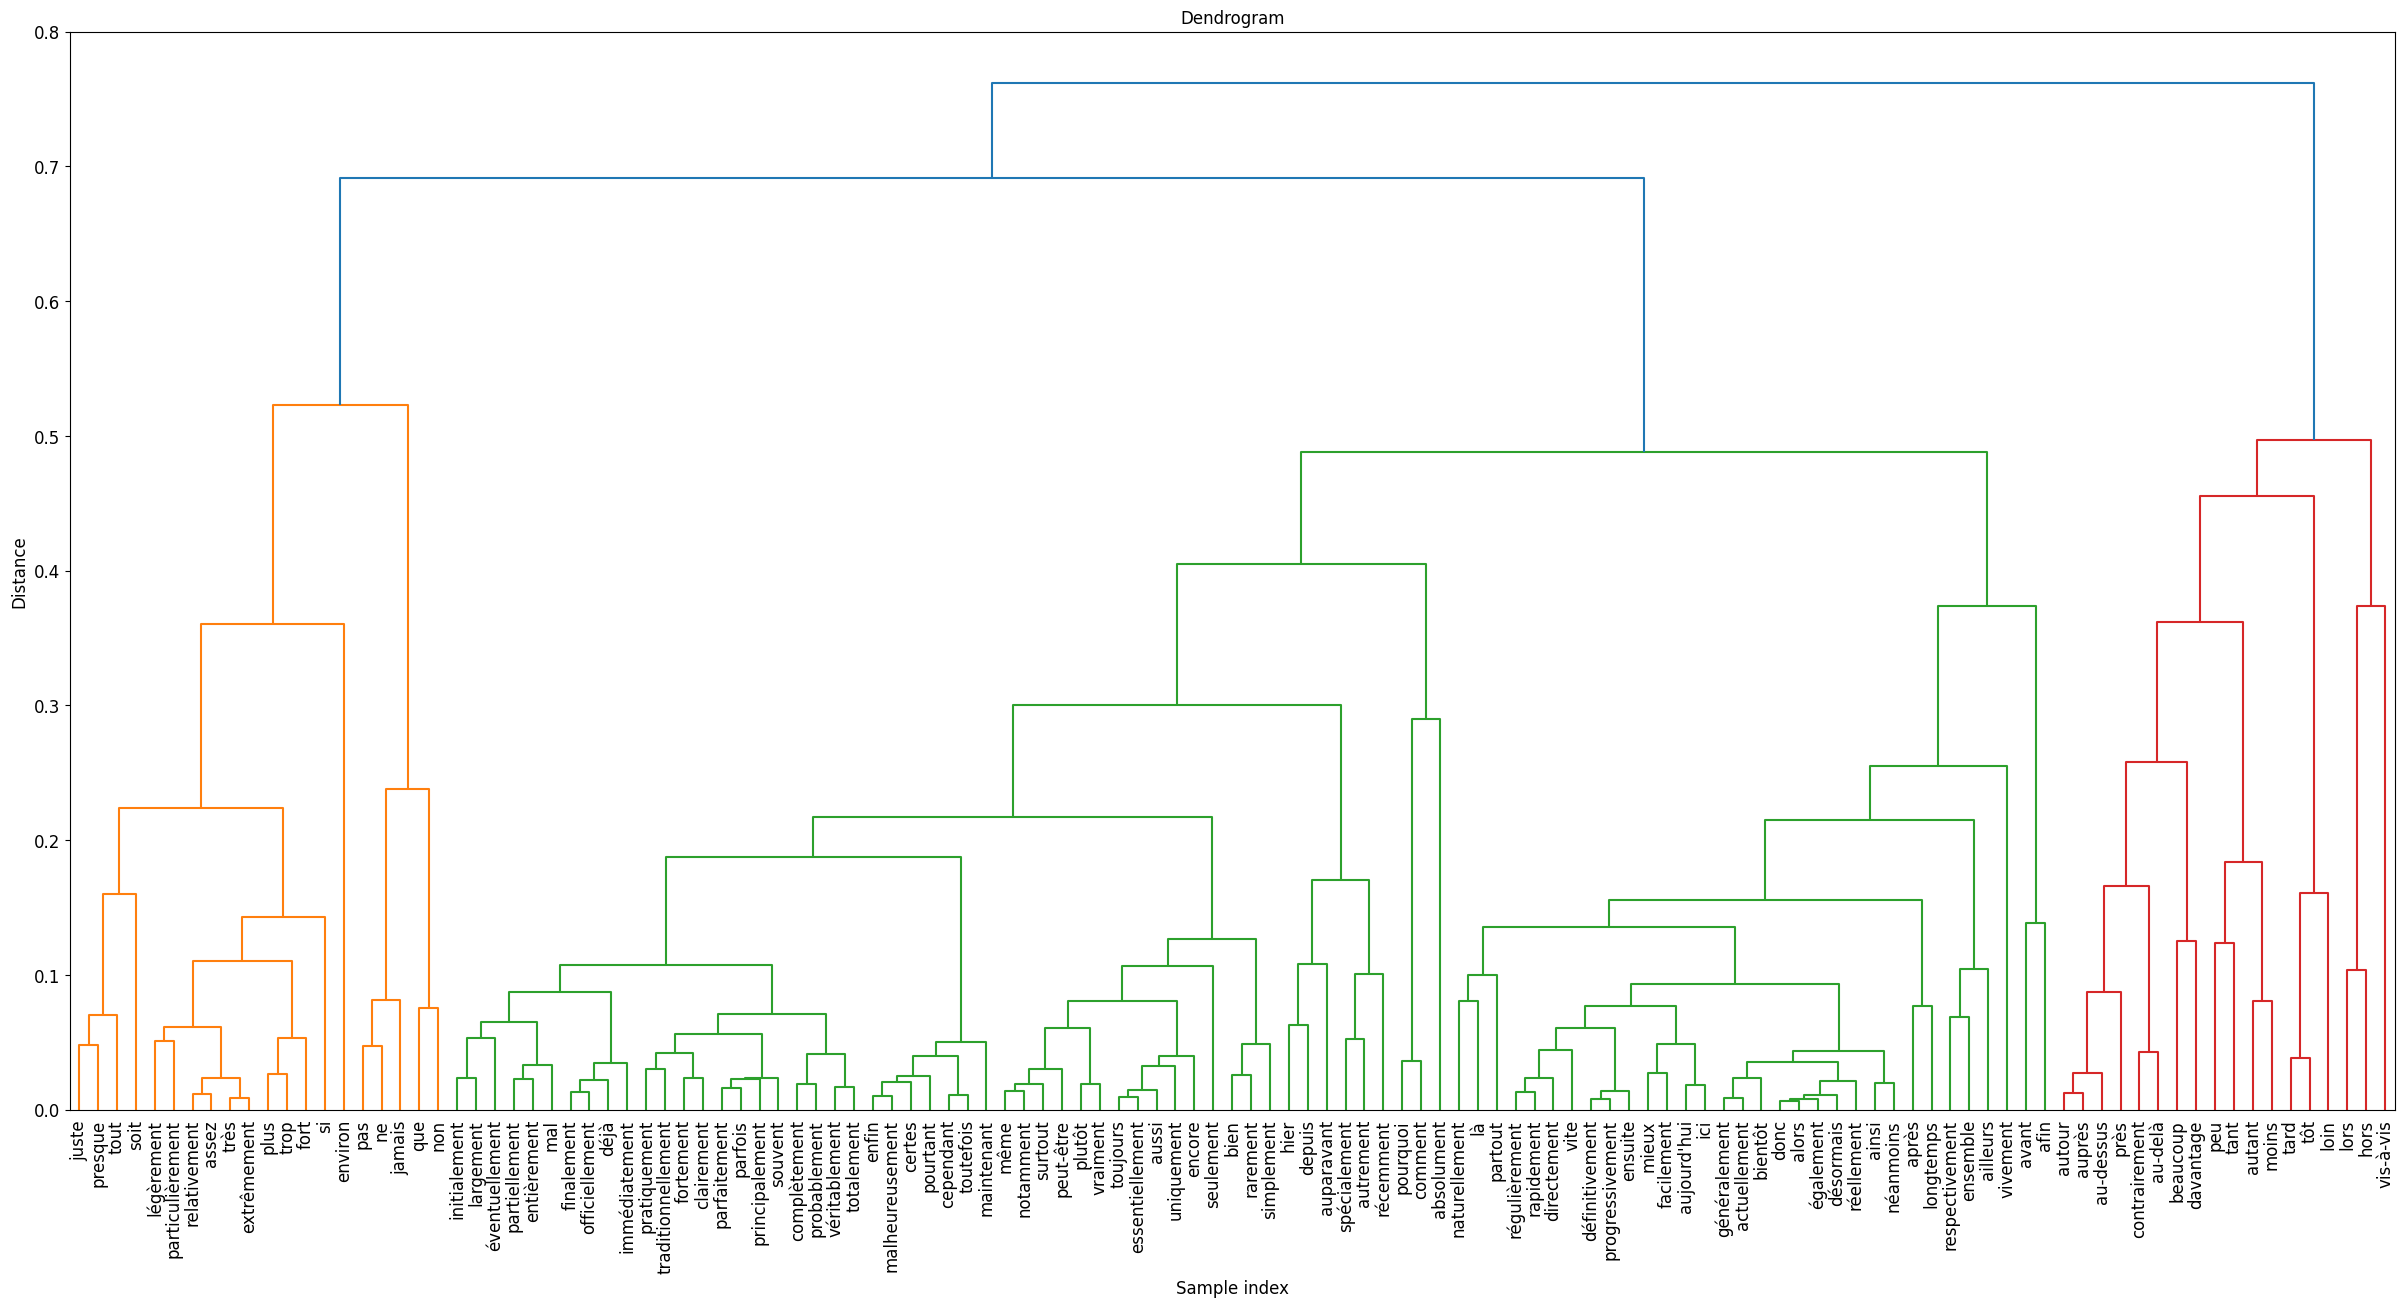

In [52]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
import matplotlib.pyplot as plt

# Hamming or jacard for categorical data, cosine for sparse matrices (normally used in NLP)
# I compute the distance for each pair of lines, each POS
distance_matrix = pdist(X, metric='cosine')
# Complete -> we cluster 
linked = linkage(distance_matrix, method="complete", optimal_ordering=True)

plt.figure(figsize=(30, 14))

dn = dendrogram(linked,
                orientation='top',
                labels=[name for name in unique_adv],
                distance_sort='descending',
                show_leaf_counts=True,
                get_leaves=True)

plt.title('Dendrogram', fontsize=12)  # Increase title font size
plt.xlabel('Sample index', fontsize=12)  # Increase x-axis label font size
plt.ylabel('Distance', fontsize=12)  # Increase y-axis label font size
plt.xticks(fontsize=12)  # Increase x-tick labels font size
plt.yticks(fontsize=12)  # Increase y-tick labels font size
plt.show()

In [53]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

def find_optimal_clusters(X, max_clusters=20, metric='cosine', method='complete'):
    distance_matrix = pdist(X, metric=metric)
    linked = linkage(distance_matrix, method=method, optimal_ordering=True)
    
    silhouette_scores = []
    for num_clusters in range(2, max_clusters + 1):
        labels = fcluster(linked, num_clusters, criterion='maxclust')
        if len(np.unique(labels)) > 1:  # Ensure there is more than one cluster
            score = silhouette_score(X, labels, metric=metric)
            silhouette_scores.append(score)
            print(f'Number of clusters: {num_clusters}, Silhouette Score: {score}')
        else:
            silhouette_scores.append(-1)  # Append a low score if only one cluster
    
    optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2
    return optimal_clusters, silhouette_scores
optimal_clusters, silhouette_scores = find_optimal_clusters(X, max_clusters=50)
print(f'Optimal number of clusters: {optimal_clusters}')
print(X.shape)

Number of clusters: 2, Silhouette Score: 0.4686437693957695
Number of clusters: 3, Silhouette Score: 0.40896904806432305
Number of clusters: 4, Silhouette Score: 0.42172624581390367
Number of clusters: 5, Silhouette Score: 0.4000010453288083
Number of clusters: 6, Silhouette Score: 0.2679539143690957
Number of clusters: 7, Silhouette Score: 0.28682023952351354
Number of clusters: 8, Silhouette Score: 0.29887585458398885
Number of clusters: 9, Silhouette Score: 0.3008290243341241
Number of clusters: 10, Silhouette Score: 0.2997643515709149
Number of clusters: 11, Silhouette Score: 0.31030825972482656
Number of clusters: 12, Silhouette Score: 0.3111926414985038
Number of clusters: 13, Silhouette Score: 0.2995359366313846
Number of clusters: 14, Silhouette Score: 0.3105006893962711
Number of clusters: 15, Silhouette Score: 0.3152655258931331
Number of clusters: 16, Silhouette Score: 0.3065408813723807
Number of clusters: 17, Silhouette Score: 0.3186533729756988
Number of clusters: 18, Sil

In [54]:
# see what there is in each cluster
labels = fcluster(linked, optimal_clusters, criterion='maxclust')
clusters = {i: [] for i in range(1, optimal_clusters + 1)}
for i, label in enumerate(labels):
    clusters[label].append(i)

for cluster, members in clusters.items():
    print(f'Cluster {cluster}:')
    for member in members:
        print(f'  {unique_adv[member]}')

Cluster 1:
  au-delà
  au-dessus
  auprès
  autant
  autour
  beaucoup
  contrairement
  davantage
  hors
  loin
  lors
  moins
  peu
  près
  tant
  tard
  tôt
  vis-à-vis
Cluster 2:
  absolument
  actuellement
  afin
  ailleurs
  ainsi
  alors
  après
  assez
  aujourd'hui
  auparavant
  aussi
  autrement
  avant
  bien
  bientôt
  cependant
  certes
  clairement
  comment
  complètement
  depuis
  directement
  donc
  définitivement
  déjà
  désormais
  encore
  enfin
  ensemble
  ensuite
  entièrement
  environ
  essentiellement
  extrêmement
  facilement
  finalement
  fort
  fortement
  généralement
  hier
  ici
  immédiatement
  initialement
  jamais
  juste
  largement
  longtemps
  là
  légèrement
  maintenant
  mal
  malheureusement
  mieux
  même
  naturellement
  ne
  non
  notamment
  néanmoins
  officiellement
  parfaitement
  parfois
  particulièrement
  partiellement
  partout
  pas
  peut-être
  plus
  plutôt
  pourquoi
  pourtant
  pratiquement
  presque
  principalem

In [55]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for Plotly
df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': labels,
    'Word': unique_adv
})
# pca1_min, pca1_max = df['PCA1'].min(), df['PCA1'].max()
# pca2_min, pca2_max = df['PCA2'].min(), df['PCA2'].max()
# Create a scatter plot with Plotly
fig = go.Figure()

# Add traces for each cluster
for cluster in range(1, optimal_clusters + 1):
    cluster_data = df[df['Cluster'] == cluster]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(size=10),
        name=f'Cluster {cluster}',
        text=cluster_data['Word'],
        hoverinfo='text'
    ))

# Update layout with dropdown menu
fig.update_layout(
    title='Word Clusters',
    xaxis_title='PCA1',
    yaxis_title='PCA2',
    # xaxis=dict(range=[pca1_min, pca1_max]),
    # yaxis=dict(range=[pca2_min, pca2_max]),
    updatemenus=[
        {
            'buttons': [
                {
                    'label': 'All Clusters',
                    'method': 'update',
                    'args': [{'visible': [True] * optimal_clusters},
                             {'title': 'All Clusters'}]
                }
            ] + [
                {
                    'label': f'Cluster {i}',
                    'method': 'update',
                    'args': [{'visible': [j == i - 1 for j in range(optimal_clusters)]},
                             {'title': f'Cluster {i}'}]
                } for i in range(1, optimal_clusters + 1)
            ],
            'direction': 'down',
            'showactive': True
        }
    ]
)

fig.show()